In [ ]:
#Connecting to Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Importing Required Libraries
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
#Reading Captions from a location
read_captions = open('/content/drive/My Drive/Datasets/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt', 'r')
text_captions = read_captions.read()
read_captions.close()

In [ ]:
print(text_captions[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [ ]:
#Creating a dictionary with keys as image ids and values as list of 5 captions
descriptions = dict()
for line in text_captions.split('\n'):
	tokens = line.split()
	image_id, image_desc = tokens[0], tokens[1:]
	image_id = image_id.split('.')[0]
	image_desc = ' '.join(image_desc)
	if image_id not in descriptions:
		descriptions[image_id] = list()
	descriptions[image_id].append(image_desc)

In [ ]:
len(descriptions)

8092

In [ ]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
#Cleaning text
for key, desc_list in descriptions.items():
	for i in range(len(desc_list)):
		desc = desc_list[i]
		# tokenize
		desc = desc.split()
		# convert to lower case
		desc = [word.lower() for word in desc]
		# remove hanging 's' and 'a'
		desc = [word for word in desc if len(word)>1]
		# remove tokens with numbers in them
		desc = [word for word in desc if word.isalpha()]
		# store as string
		desc_list[i] =  ' '.join(desc)

In [ ]:
len(descriptions)

8092

In [ ]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
# convert the loaded descriptions into a vocabulary of words(This are all unique words in captions)
list_vocab=[]
for a in descriptions.values():
  b=(a[0]+' '+a[1]+' '+a[2]+' '+a[3]+' '+a[4]).split()
  for c in b:
    list_vocab.append(c)

vocabulary=set(list_vocab)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8357


In [ ]:
#Loading the training image ids
file_train_images = open('/content/drive/My Drive/Datasets/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt', 'r')
text_train_images = file_train_images.read()
file_train_images.close()

list_train_images=[]
for i in text_train_images.split('\n'):
  list_train_images.append(i.split('.')[0])

list_train_images=list_train_images[0:6000]
train=set(list_train_images)

In [ ]:
len(train)

6000

In [ ]:
#Loading the test image ids
file_test_images = open('/content/drive/My Drive/Datasets/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt', 'r')
text_test_images = file_test_images.read()
file_test_images.close()

list_test_images=[]
for i in text_test_images.split('\n'):
  list_test_images.append(i.split('.')[0])

list_test_images=list_test_images[0:1000]
test=set(list_test_images)

In [ ]:
len(test)

1000

In [ ]:
#Taking locations of all the images in variable 'img'(This is a list)
images = '/content/drive/My Drive/Datasets/Flickr_Data/Flickr_Data/Images'
img=glob.glob('/content/drive/My Drive/Datasets/Flickr_Data/Flickr_Data/Images/*.jpg')

In [ ]:
img[0]

'/content/drive/My Drive/Datasets/Flickr_Data/Flickr_Data/Images/3732728142_86364a706e.jpg'

In [ ]:
#Locations of all the train images
train_img=[]

for i in list_train_images:
  train_img.append('/content/drive/My Drive/Datasets/Flickr_Data/Flickr_Data/Images/'+i+'.jpg')

In [ ]:
train_img[0]

'/content/drive/My Drive/Datasets/Flickr_Data/Flickr_Data/Images/2513260012_03d33305cf.jpg'

In [ ]:
len(train_img)

6000

In [ ]:
#Locations of all the test images
test_img=[]

for i in list_test_images:
  test_img.append('/content/drive/My Drive/Datasets/Flickr_Data/Flickr_Data/Images/'+i+'.jpg')

In [ ]:
test_img[0]

'/content/drive/My Drive/Datasets/Flickr_Data/Flickr_Data/Images/3385593926_d3e9c21170.jpg'

In [ ]:
len(test_img)

1000

In [ ]:
#Taking all the list of training descriptions in dictionary with keys as image id and values as captions
train_desc={}
for i in list_train_images:
  train_desc[i]=descriptions[i]

In [ ]:
#Adding startseq and endseq for every caption
train_descriptions={}
for key, desc in train_desc.items():
  for i in range(0,len(desc)):
    if key not in train_descriptions:
      train_descriptions[key] = list()
    train_descriptions[key].append('startseq '+desc[i]+' endseq')

In [ ]:
train_descriptions['2513260012_03d33305cf']

['startseq black dog is running after white dog in the snow endseq',
 'startseq black dog chasing brown dog through snow endseq',
 'startseq two dogs chase each other across the snowy ground endseq',
 'startseq two dogs play together in the snow endseq',
 'startseq two dogs running through low lying body of water endseq']

In [ ]:
#Function to preprocess and resize images
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [ ]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [ ]:
model_new.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
# Call the funtion to encode all the train images
# This will take time
from tqdm import tqdm
start = time()
encoding_train = {}
for img in list_train_images:
    encoding_train[img] = encode(img)
print("Time taken in seconds =", time()-start)


# Save the bottleneck train features to disk
import pickle
with open("/content/drive/My Drive/Datasets/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [ ]:
# Call the funtion to encode all the test images - Execute this only once
# This will take time
start = time()
encoding_test = {}
for img in list_test_images:
    encoding_test[img] = encode(img)
print("Time taken in seconds =", time()-start)

# Save the bottleneck test features to disk
with open("/content/drive/My Drive/Datasets/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [ ]:
train_features = load(open("/content/drive/My Drive/Datasets/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [ ]:
encoding_test = load(open("/content/drive/My Drive/Datasets/encoded_test_images.pkl", "rb"))
print('Photos: train=%d' % len(encoding_test))

Photos: train=1000


In [ ]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
#Removing words with occur less than 10 times
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1, 1))
vectorizer.fit_transform(all_train_captions)

<30000x1638 sparse matrix of type '<class 'numpy.int64'>'
	with 312153 stored elements in Compressed Sparse Row format>

In [ ]:
len(vectorizer.get_feature_names())

1638

In [ ]:
vocab=vectorizer.get_feature_names()

In [ ]:
vocab[0:10]

['about',
 'above',
 'accordion',
 'across',
 'action',
 'adult',
 'adults',
 'advertisement',
 'advertising',
 'african']

In [ ]:
#Creating 2 dict. One has index to word and other has word to index mapping
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [ ]:
#Since we start indexing from 1. So we need to add 1 to compensate the length
vocab_size = len(ixtoword) + 1
vocab_size

1639

In [ ]:
#Calculating max length so that we can come to know the limit for zero padding
len_captions=[]
for key,desc in descriptions.items():
  for i in range(0,len(desc)):
    len_captions.append(len((descriptions[key][i]).split()))

print('Max Description Length:',max(len_captions)+2)
max_length=max(len_captions)+2

Max Description Length: 33


In [ ]:
#Function to create data.
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos['/'+key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [ ]:
# Load Glove vectors. 200 dimensional.
glove_dir = '/content/drive/My Drive/Datasets'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
#Creates a matrix with all the words in vocabulary
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(1639, 200)

In [ ]:
#Creating Model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 33, 200)      327800      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
#Fixing weights for Embedding layer which is the glove vectors. We make it non-trainable.
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 181s 181ms/step - loss: 4.2214
Epoch 1/1
1000/1000 [==============================] - 178s 178ms/step - loss: 3.4752
Epoch 1/1
1000/1000 [==============================] - 178s 178ms/step - loss: 3.2401
Epoch 1/1
1000/1000 [==============================] - 175s 175ms/step - loss: 3.0984
Epoch 1/1
1000/1000 [==============================] - 177s 177ms/step - loss: 2.9947
Epoch 1/1
1000/1000 [==============================] - 177s 177ms/step - loss: 2.9171
Epoch 1/1
1000/1000 [==============================] - 176s 176ms/step - loss: 2.8516
Epoch 1/1
1000/1000 [==============================] - 177s 177ms/step - loss: 2.7960
Epoch 1/1
1000/1000 [==============================] - 175s 175ms/step - loss: 2.7479
Epoch 1/1
1000/1000 [==============================] - 176s 176ms/step - loss: 2.7049


In [ ]:
epochs=5
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 177s 177ms/step - loss: 2.6714
Epoch 1/1
1000/1000 [==============================] - 179s 179ms/step - loss: 2.6388
Epoch 1/1
1000/1000 [==============================] - 178s 178ms/step - loss: 2.6104
Epoch 1/1
1000/1000 [==============================] - 178s 178ms/step - loss: 2.5851
Epoch 1/1
1000/1000 [==============================] - 176s 176ms/step - loss: 2.5612


In [ ]:
epochs=5
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch 1/1
1000/1000 [==============================] - 179s 179ms/step - loss: 2.5394
Epoch 1/1
1000/1000 [==============================] - 179s 179ms/step - loss: 2.5205
Epoch 1/1
1000/1000 [==============================] - 179s 179ms/step - loss: 2.4995
Epoch 1/1
1000/1000 [==============================] - 179s 179ms/step - loss: 2.4817
Epoch 1/1
1000/1000 [==============================] - 181s 181ms/step - loss: 2.4682


In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [ ]:
#Saving Model
model.save_weights('/content/drive/My Drive/Datasets/model_LSTM_20.h5')

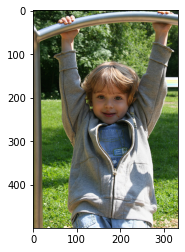

Greedy: fabric fabric gliding gliding gliding gliding fabric gliding gliding gliding gliding fabric gliding gliding gliding gliding gliding gliding gliding gliding gliding gliding gliding gliding gliding gliding gliding gliding gliding gliding gliding gliding


In [ ]:
#Displaying output before training
z=25
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

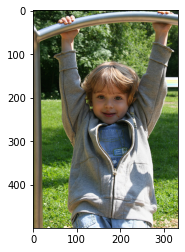

Greedy: child in blue shirt is jumping off of swing set


In [ ]:
#Displaying output after training
z=25
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

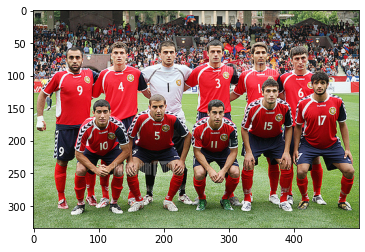

Greedy: group of men in martial arts uniforms and white uniforms are playing game


In [ ]:
z=3
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))